#Face Recognition

With the power of CNN.

Implemented By Muhammad Hanan Asghar

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#Data Setup and Preprocessing

In [ ]:
!cp "/content/drive/MyDrive/cropped.zip" "/content"
!unzip *.zip && rm -rf *.zip

In [3]:
# Collecting Negatives

# Import uuid library to generate unique image names
import uuid


!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz


# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

--2022-03-03 17:31:19--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  32.4MB/s    in 5.9s    

2022-03-03 17:31:25 (29.2 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [4]:
import dlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import uuid

# Detector Model(Face)
detector = dlib.get_frontal_face_detector()

In [5]:
def gen_faces(image):
    """
    Function that gets image as input and generate face from it and returns
    face from the image.
    """
    image_height, image_width, _ = image.shape
    faces = []
    detections = detector(image)
    for i, d in enumerate(detections):
        # Croping Face from image
        crop_img = image[max(0, d.top()): min(d.bottom(), image_height),
                    max(0, d.left()): min(d.right(), image_width)]
        faces.append(crop_img)
#     returning array of faces
    return faces

In [6]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join("/content/negative", file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
import glob

images = glob.glob("/content/negative/*")
for image in images:
  try:
    frame = cv2.imread(image)
    face = gen_faces(frame)[0]
    filename = f"/content/cropped/negative/{uuid.uuid1()}.jpg"
    cv2.imwrite(filename, face)
    print(f"Saved: {filename}")
  except:
    print("Error Occured")

In [8]:
!rm -rf *.zip && rm -rf *.tgz

In [9]:
!rm -rf /content/negative
!rm -rf /content/lfw

In [10]:
IMG_WIDTH = 96
IMG_HEIGHT = 96
BATCH_SIZE = 32
EPOCHS = 100

In [11]:
import tensorflow as tf

In [12]:
!pip install split-folders


import splitfolders
splitfolders.ratio('cropped', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 56627 files [00:10, 5392.93 files/s]


In [13]:
!rm -rf "/content/output/train/.ipynb_checkpoints"
!rm -rf "/content/output/test/.ipynb_checkpoints"
!rm -rf "/content/output/val/.ipynb_checkpoints"

In [30]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=45,
                                   horizontal_flip=True,
                                   vertical_flip=True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory("/content/output/train",
                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=BATCH_SIZE,
                                     class_mode='categorical')

test_set = test_datagen.flow_from_directory("/content/output/test",
                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=BATCH_SIZE,
                                     class_mode='categorical')

val_set = test_datagen.flow_from_directory("/content/output/val",
                                       target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                batch_size=BATCH_SIZE,
                                     class_mode='categorical')

Found 45301 images belonging to 4 classes.
Found 5665 images belonging to 4 classes.
Found 5661 images belonging to 4 classes.


In [32]:
class_names = training_set.class_indices
num_classes =len(class_names)
print(class_names, num_classes)

{'arham': 0, 'ehsan': 1, 'mohsin': 2, 'negative': 3} 4


In [34]:
model = tf.keras.models.Sequential([

  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=512, activation="relu"),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Dense(units=512, activation="relu"),
  tf.keras.layers.Dense(units=num_classes, activation="softmax")
])

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 24, 24, 64)       

In [36]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [37]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [38]:
history = model.fit(
  training_set,
  validation_data = test_set,
  epochs = EPOCHS,
  callbacks = callbacks,
)

Epoch 1/100
1416/1416 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.8921
Epoch 1: val_loss improved from inf to 0.06287, saving model to model.h5
1416/1416 [==============================] - 169s 112ms/step - loss: 0.2704 - accuracy: 0.8921 - val_loss: 0.0629 - val_accuracy: 0.9838
Epoch 2/100
1416/1416 [==============================] - ETA: 0s - loss: 0.0495 - accuracy: 0.9842
Epoch 2: val_loss improved from 0.06287 to 0.03007, saving model to model.h5
1416/1416 [==============================] - 156s 110ms/step - loss: 0.0495 - accuracy: 0.9842 - val_loss: 0.0301 - val_accuracy: 0.9924
Epoch 3/100
1416/1416 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9891
Epoch 3: val_loss improved from 0.03007 to 0.01998, saving model to model.h5
1416/1416 [==============================] - 156s 110ms/step - loss: 0.0341 - accuracy: 0.9891 - val_loss: 0.0200 - val_accuracy: 0.9938
Epoch 4/100
1416/1416 [==============================] - ETA: 0s 

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

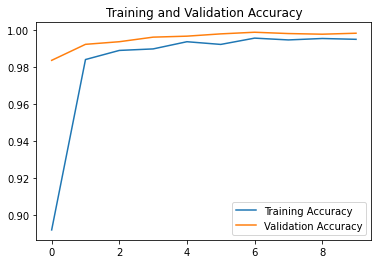

In [40]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

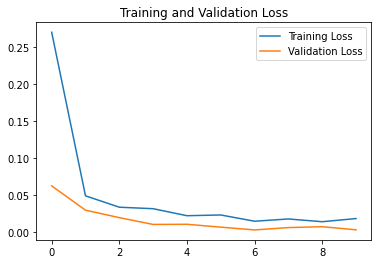

In [41]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
loss, accuracy = model.evaluate(val_set)

177/177 [==============================] - 10s 54ms/step - loss: 0.0050 - accuracy: 0.9986


In [43]:
# Reload model 
cnn = tf.keras.models.load_model('model.h5', compile=True)

In [44]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(cnn)
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_poocsg0/assets


21493580

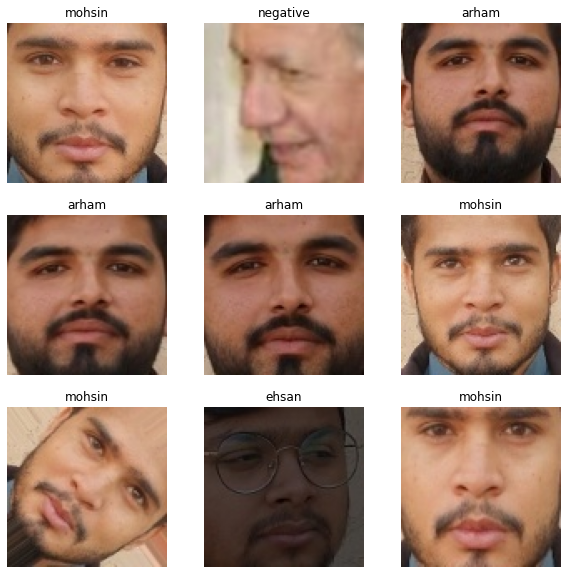

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    pred = cnn.predict(tf.expand_dims(images[i], 0))
    plt.title(class_names[labels[i]])
    plt.ylabel(class_names[np.argmax(tf.nn.softmax(pred))])
    plt.axis("off")